In [1]:
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from tqdm import tqdm
from scoring import *

# f = "../../data/original/Ugly/10.pdf"
# f = "../../data/original/Ugly/2.pdf"
# f = "../../data/original/Ugly/000.895.652.pdf"
# f = "../../data/original/Good/300-014823.pdf"
f = "../../data/original/Good/300-014822.pdf"

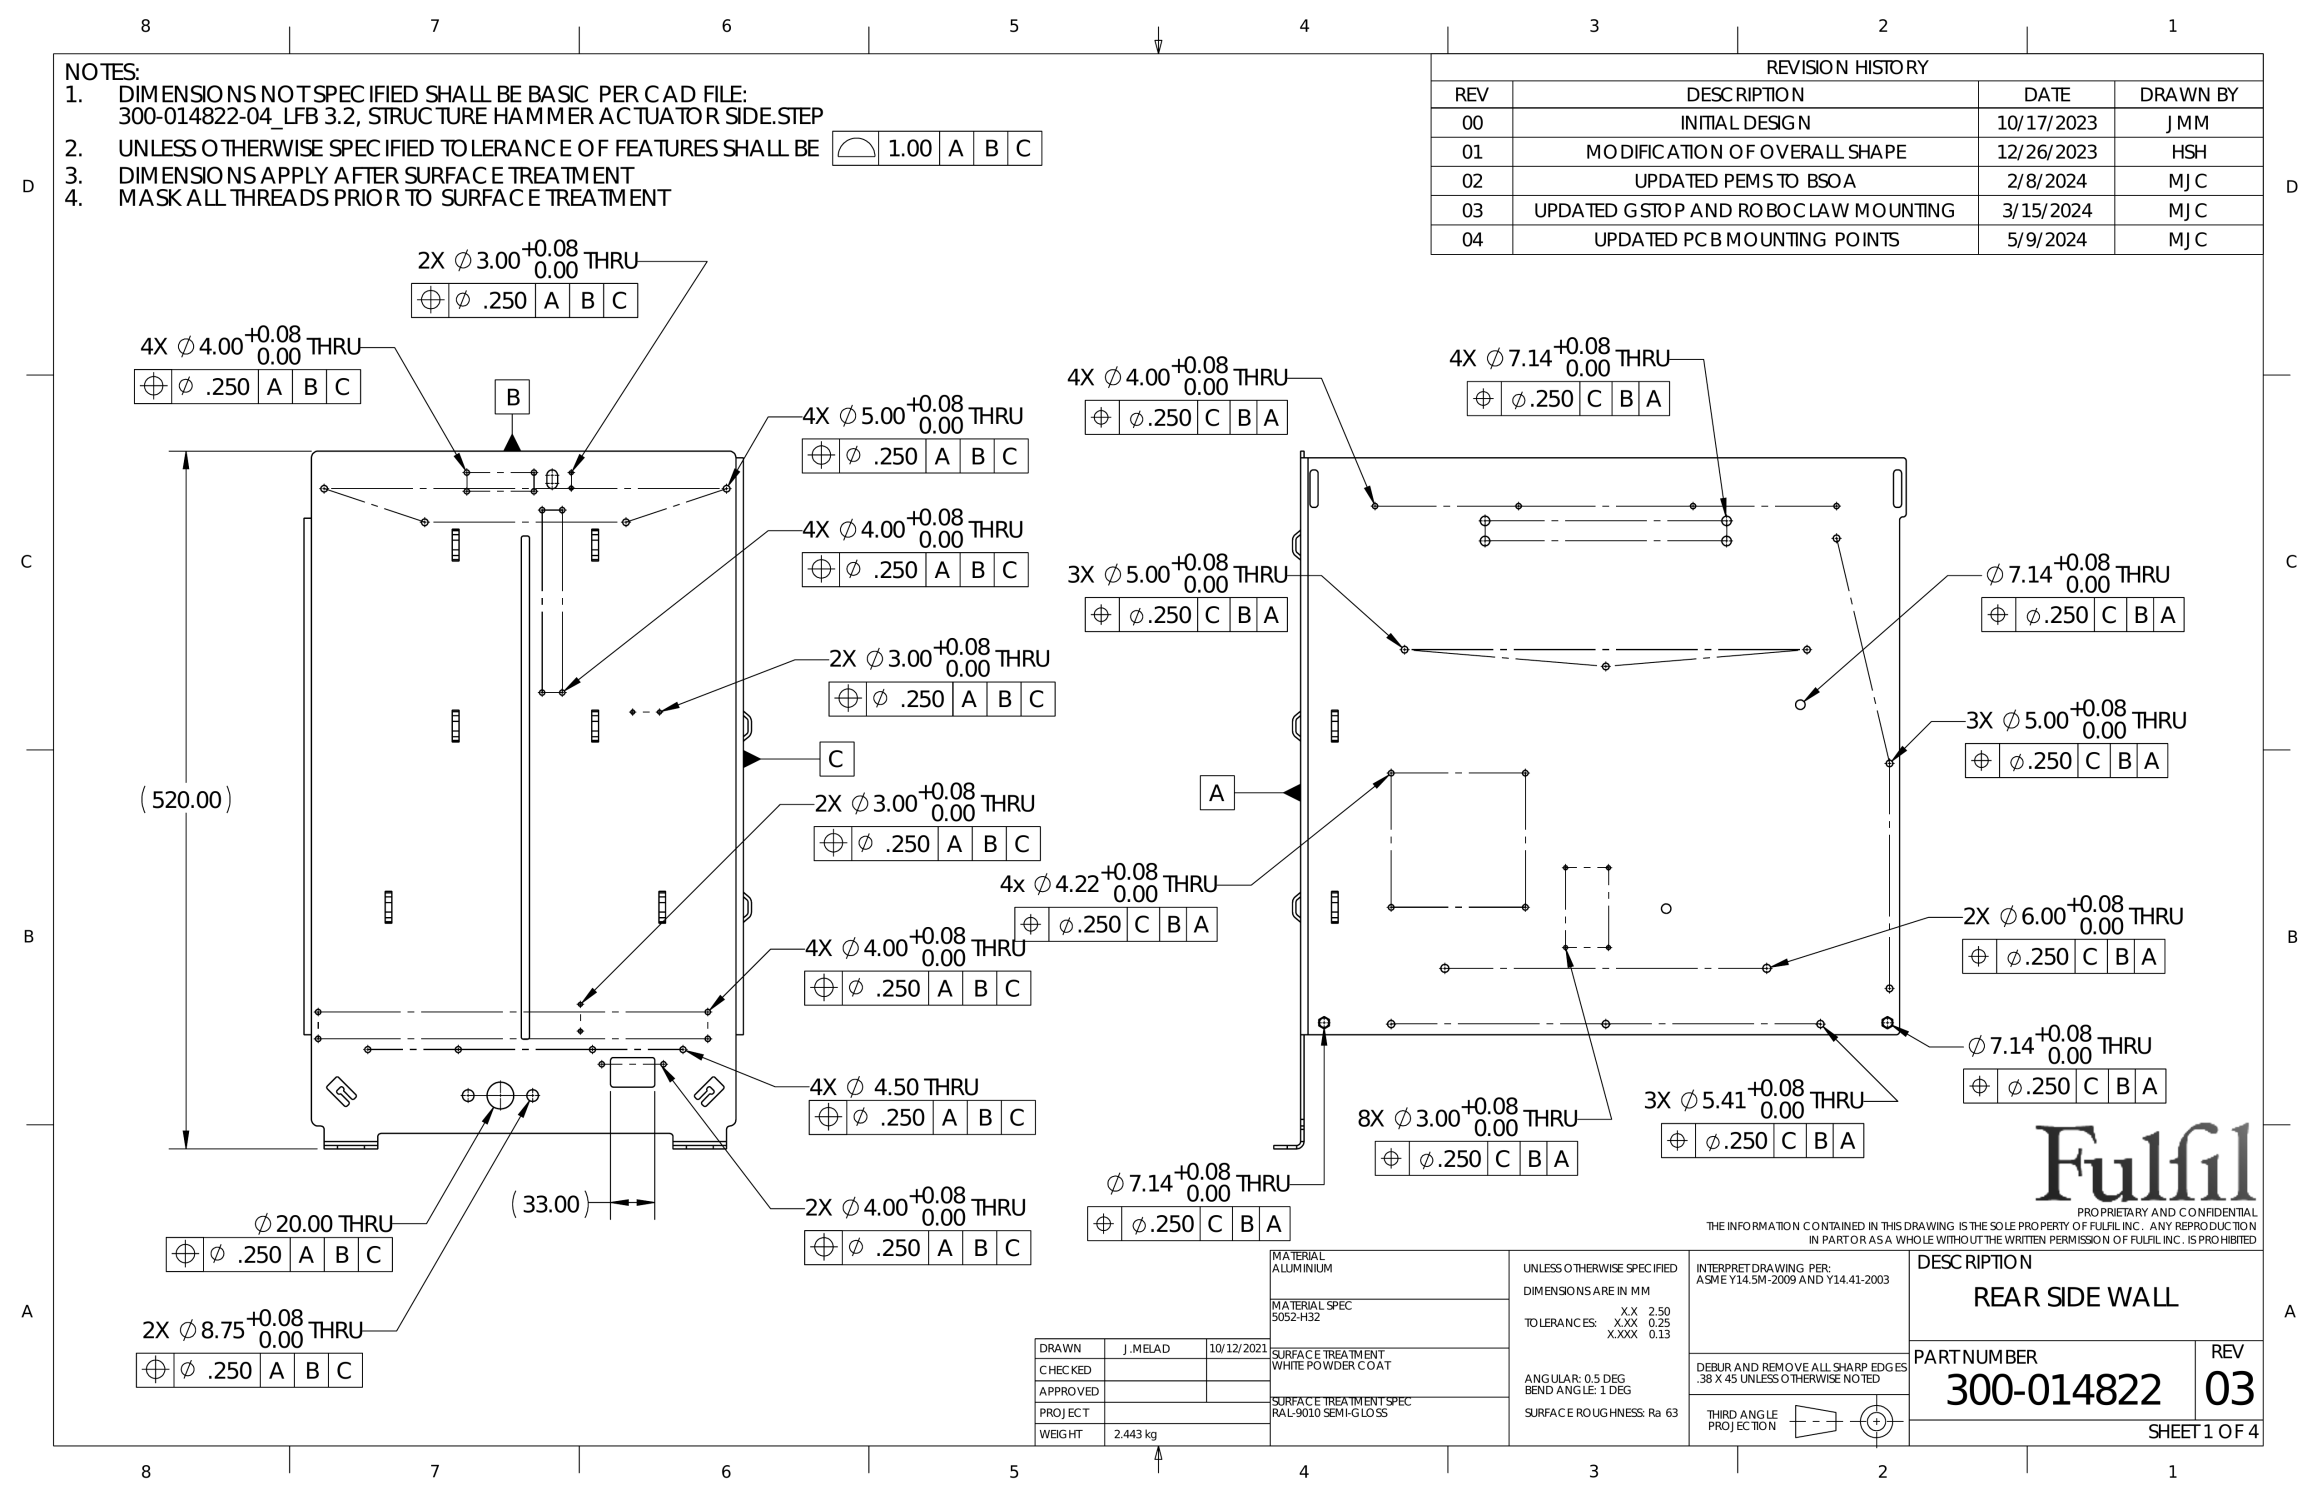

In [2]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

pages = convert_from_path(f, dpi=300)
img = np.array(pages[0])
img = im_resize(img)
img_comp = img.copy()

Image.fromarray(img_comp)

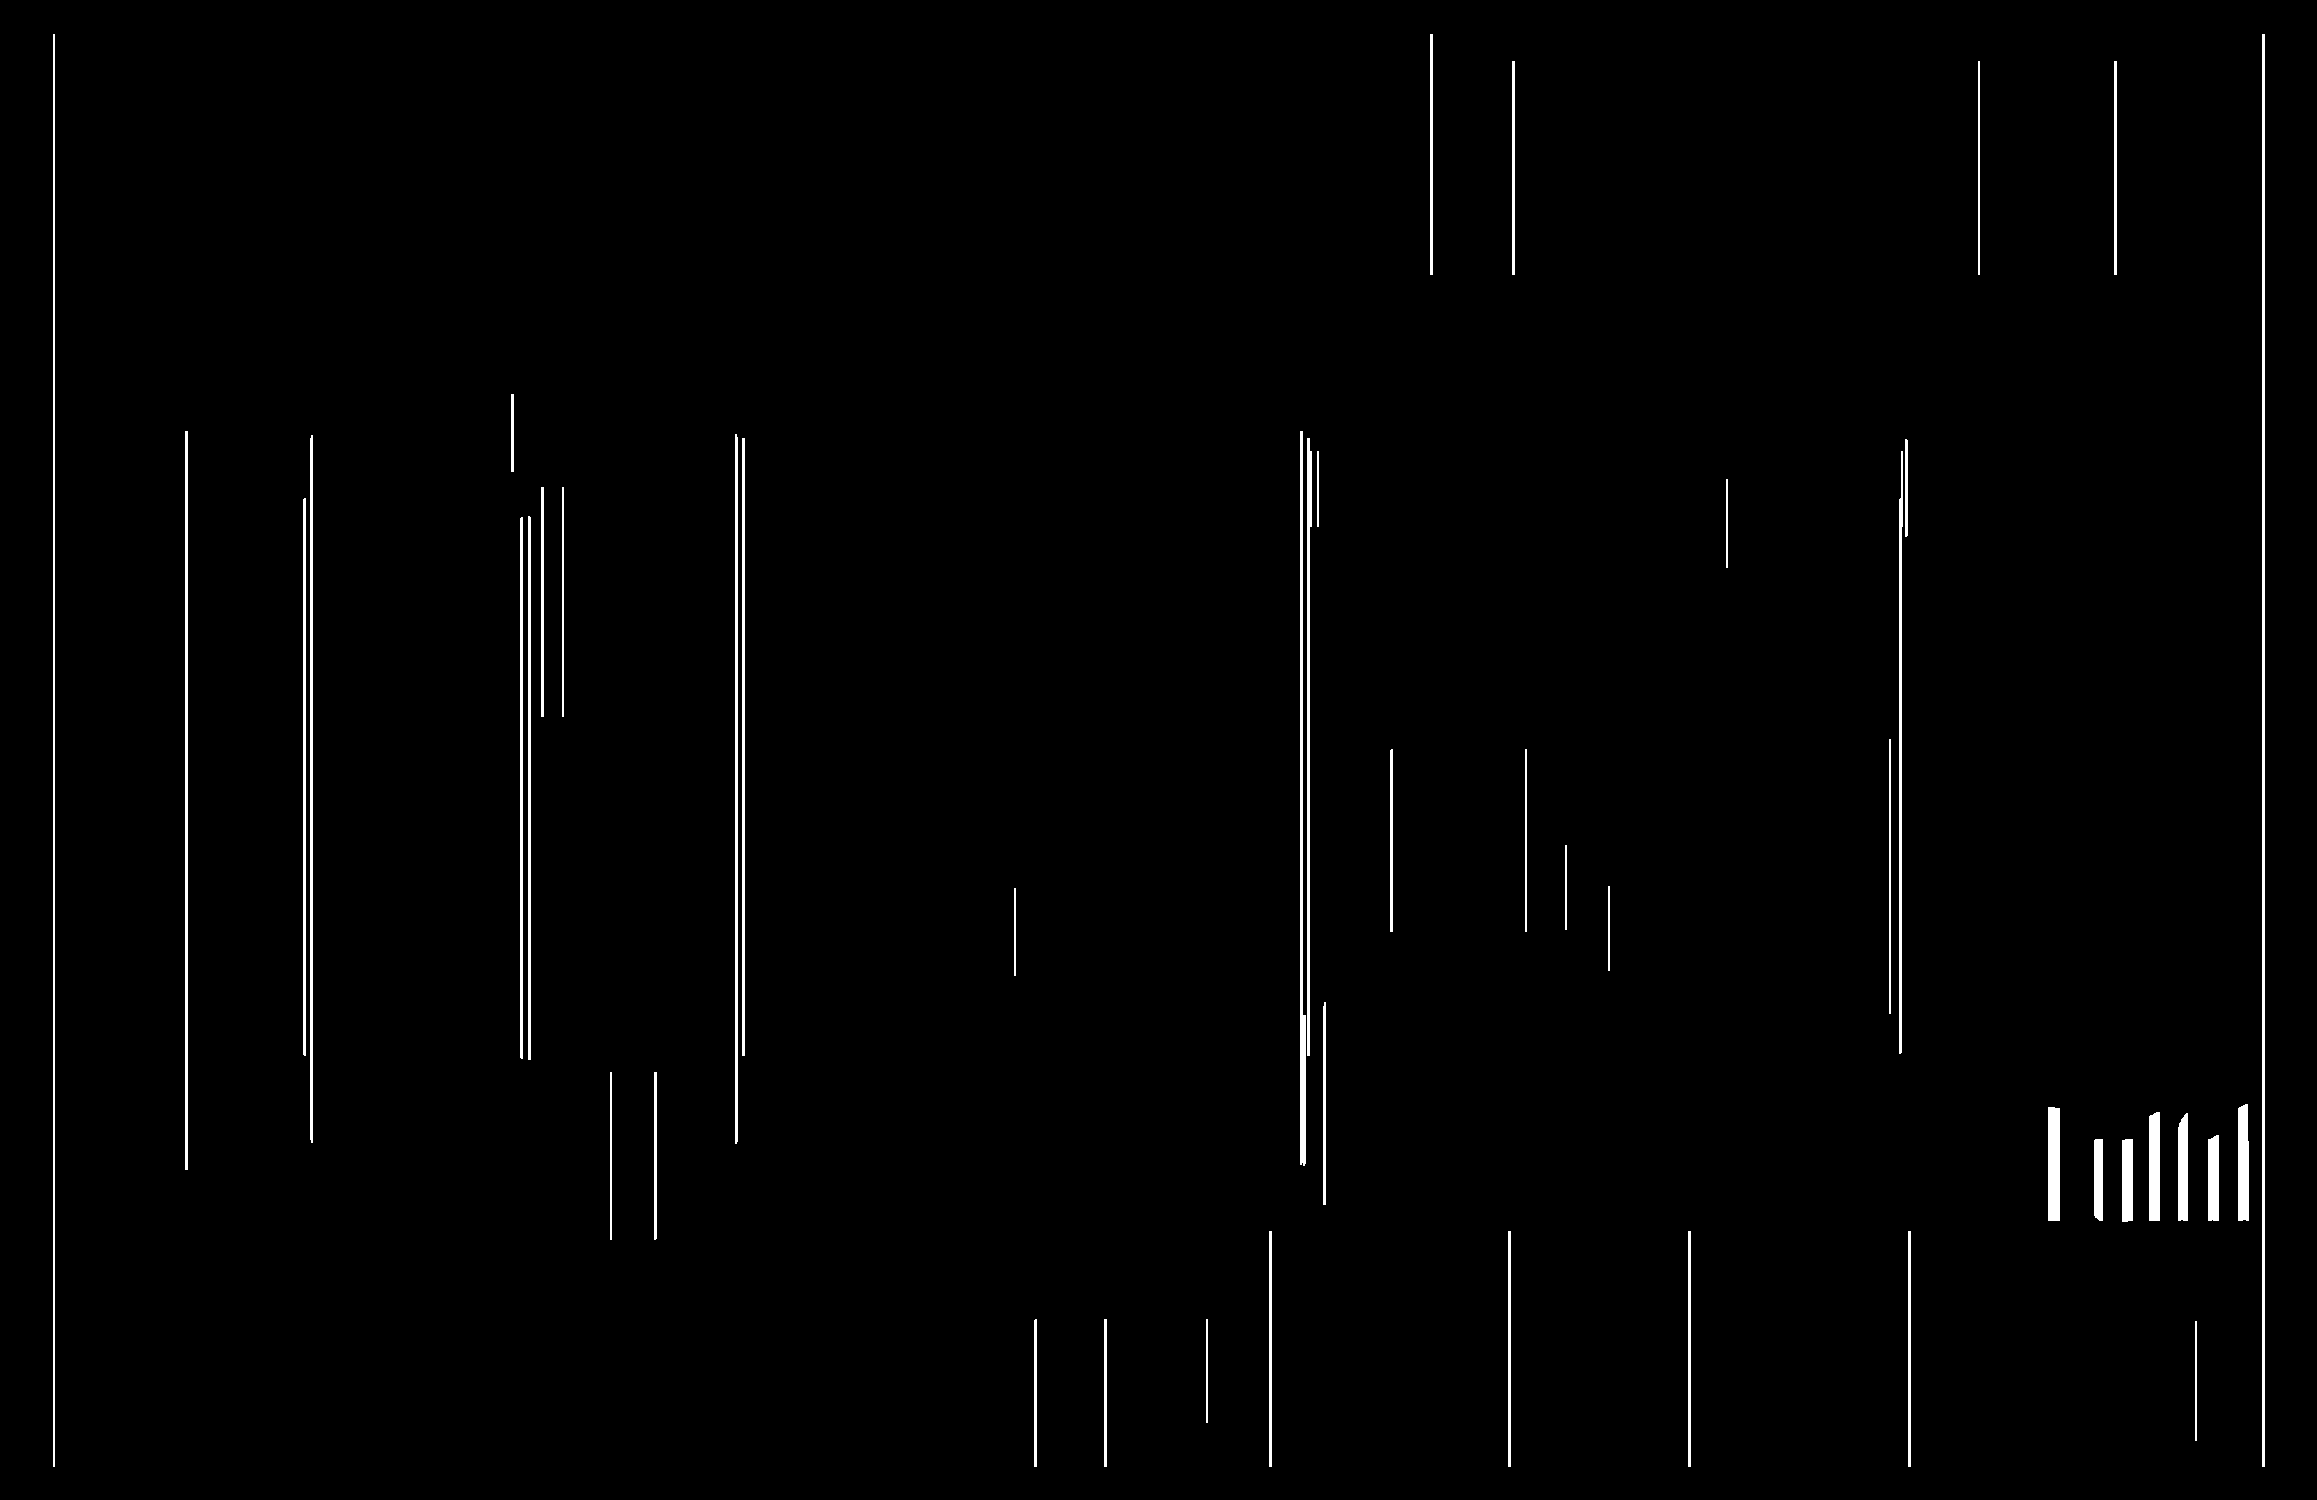

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_bin = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
image_height, image_width = img_bin.shape

SCALE = 40
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, image_height // SCALE))
vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
vertical_lines = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 40)))

# lines_30 = cv2.HoughLinesP(vertical_lines, 1, np.pi / 180, 15, np.array([]), int((image_height * 5) / 100), 10)
# for line in lines_30:
#     for x1,y1,x2,y2 in line:
#         if y1 > int((image_height * 80) / 100) and y2 > int((image_height * 80) / 100):
#             print(x1,y1,x2,y2)
#             cv2.line(vertical_lines, (x1,y1), (x2,y2), (255,255,255) , 3)

Image.fromarray(vertical_lines)

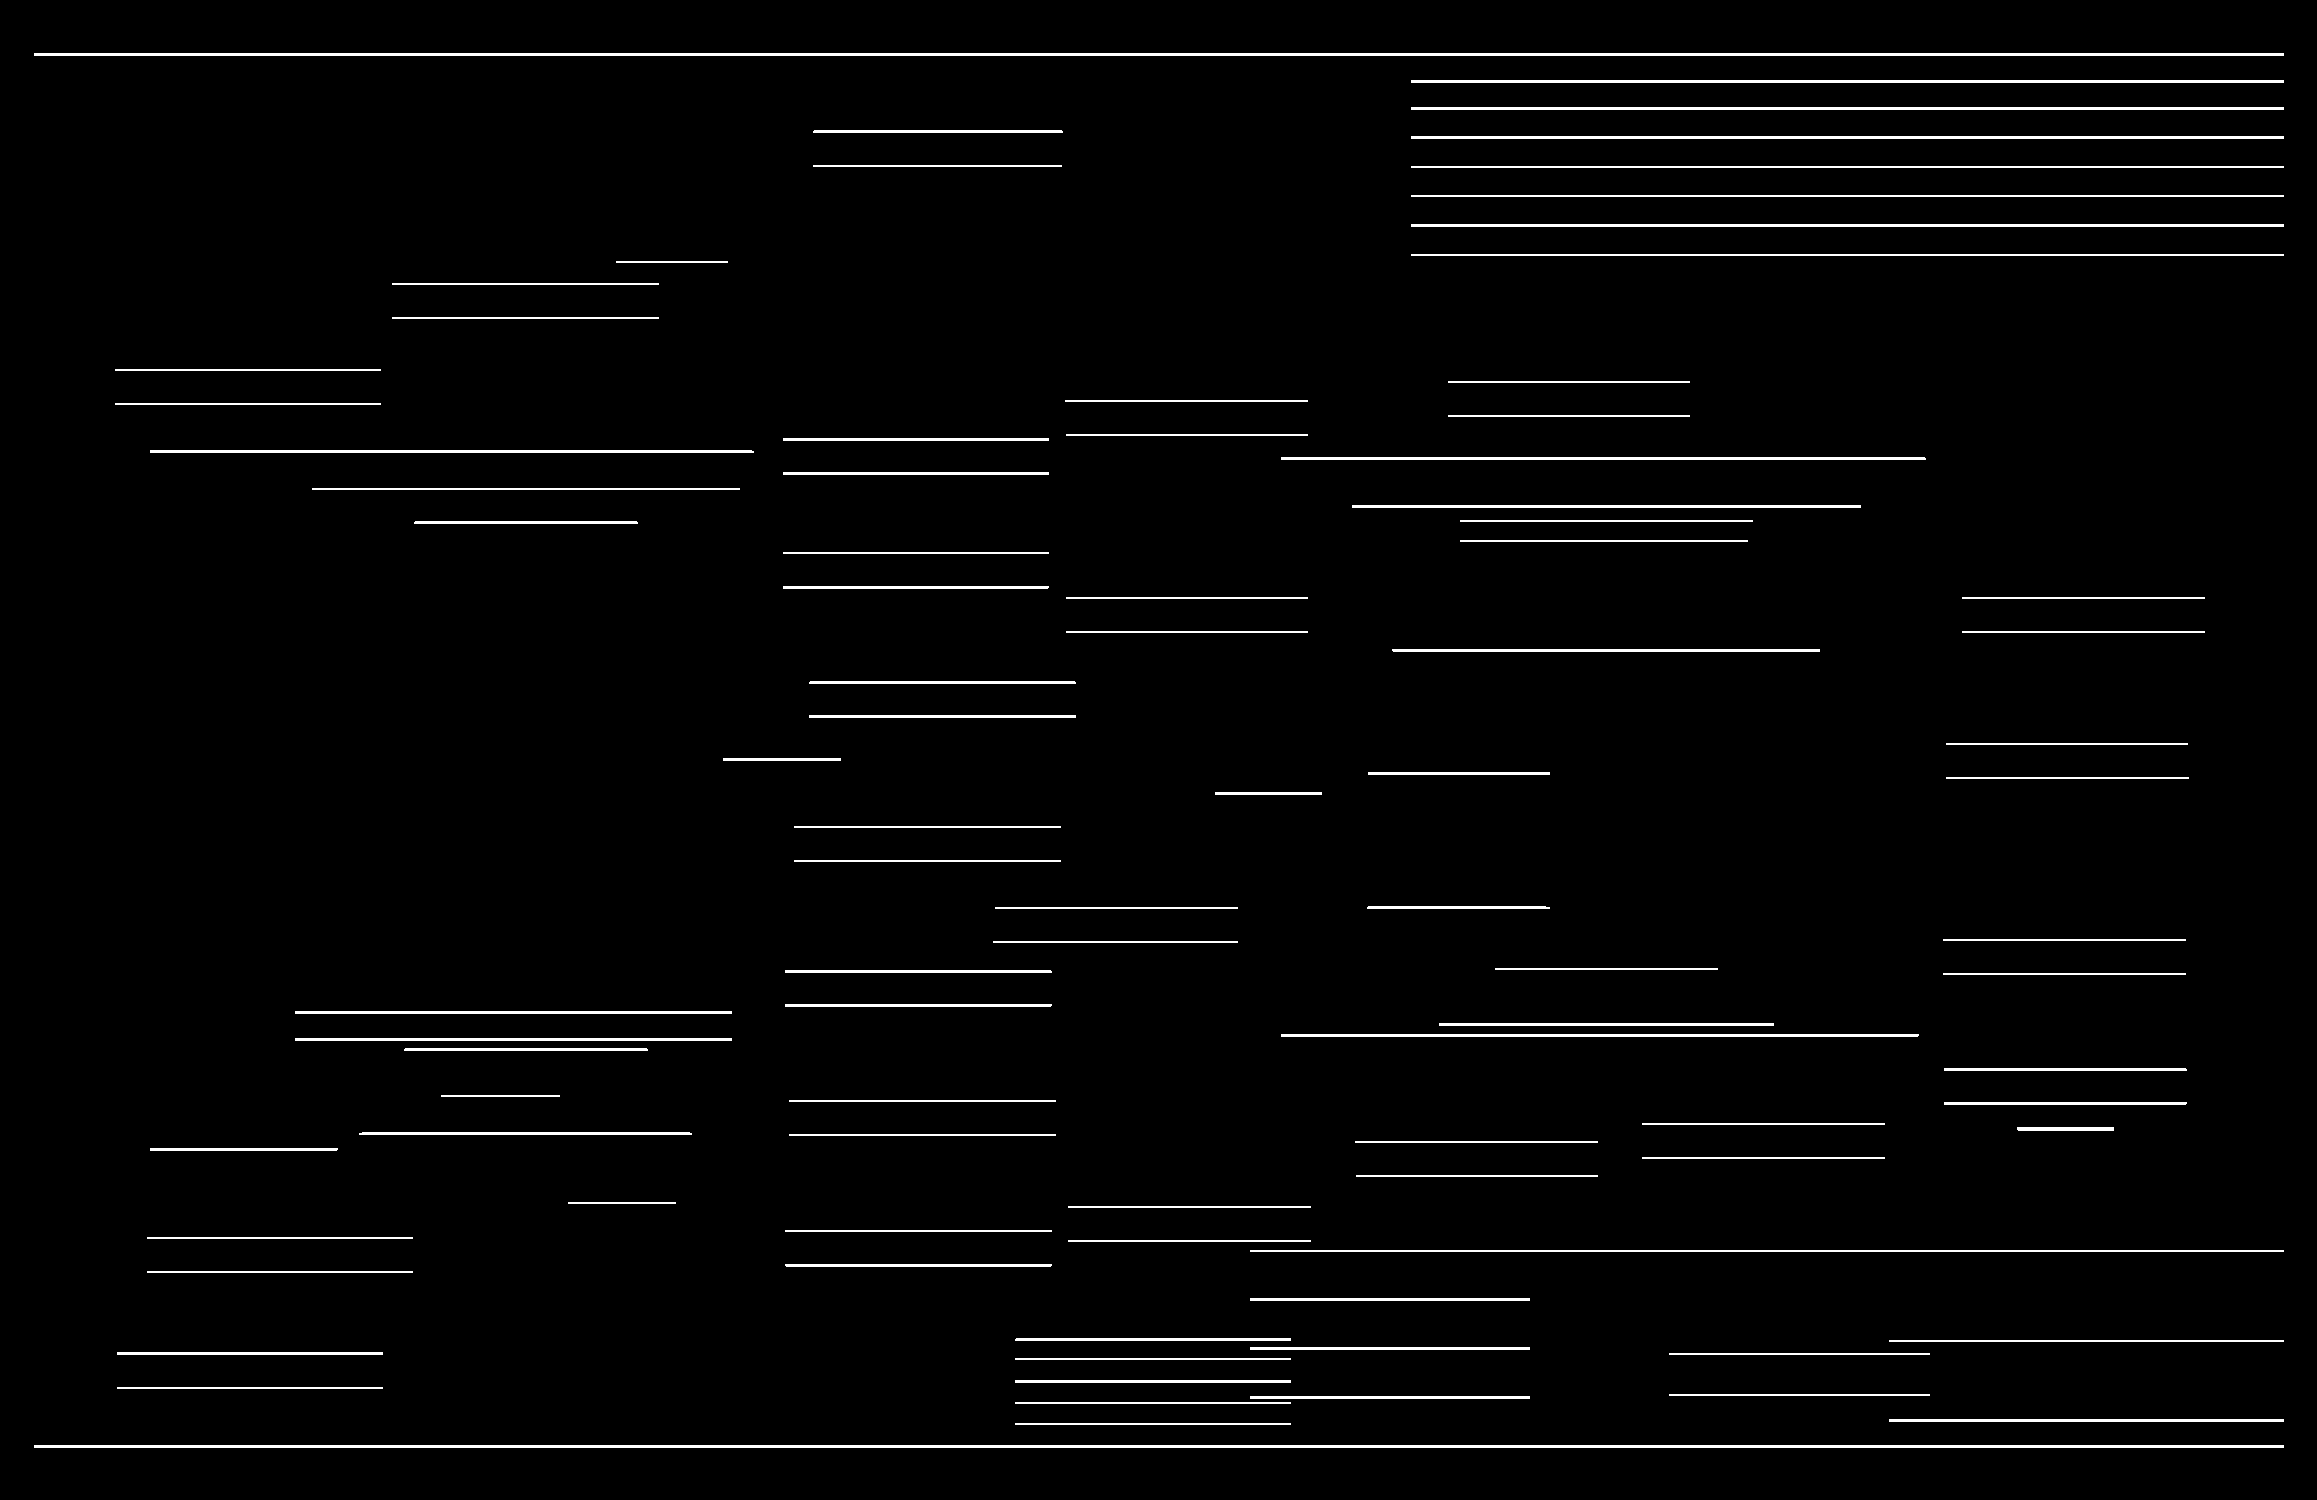

In [4]:
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (image_width // SCALE, 1))
horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
horizontal_lines = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 2)))

lines = cv2.HoughLinesP(horizontal_lines, 1, np.pi / 180, 15, np.array([]), int((image_width * 95) / 100), 50)

for line in lines:
    for x1,y1,x2,y2 in line:
        if (
                y1 > int((image_height * 80) / 100) and y2 > int((image_height * 80) / 100)
        ) and (
                y1 < int((image_height * 88) / 100) and y2 < int((image_height * 88) / 100)
        ):
            cv2.line(horizontal_lines, (x1,y1), (x2,y2), (255,255,255) , 5)

# lines_30 = cv2.HoughLinesP(horizontal_lines, 1, np.pi / 180, 15, np.array([]), int((image_width * 5) / 100), 10)
# for line in lines_30:
#     for x1,y1,x2,y2 in line:
#         if y1 > int((image_height * 80) / 100) and y2 > int((image_height * 80) / 100):
#             cv2.line(horizontal_lines, (x1,y1), (x2,y2), (255,255,255) , 3)

Image.fromarray(horizontal_lines)

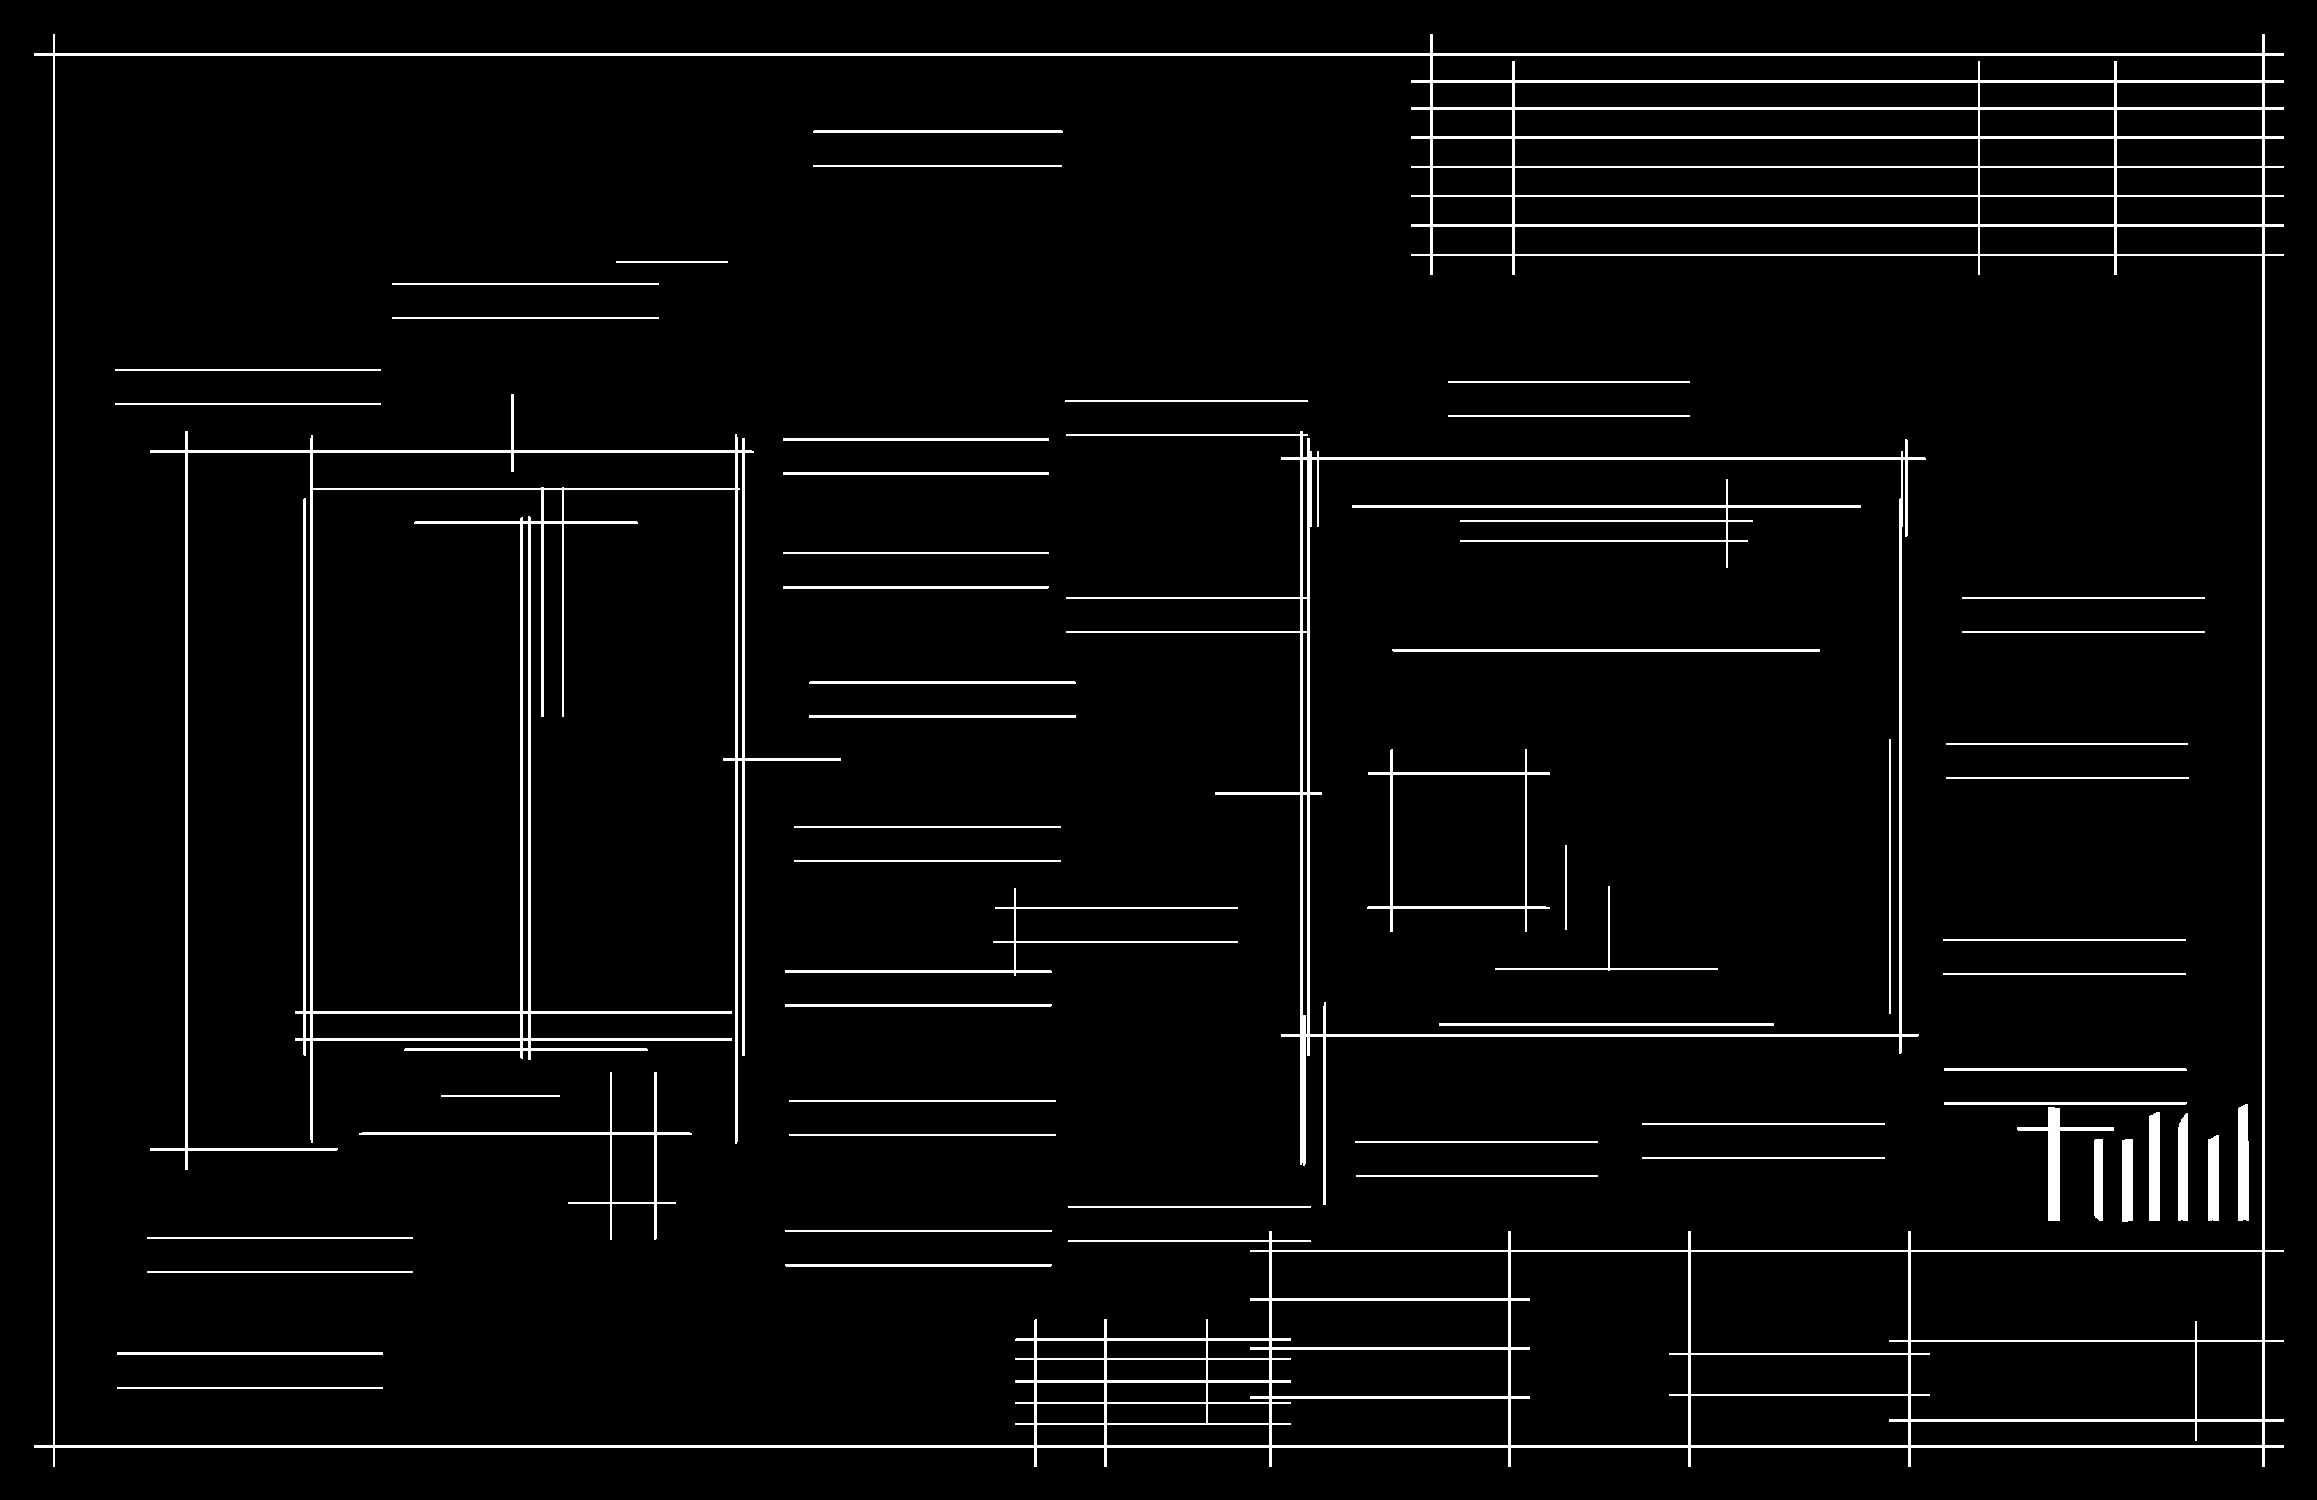

In [5]:
# merged_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
merged_lines = vertical_lines + horizontal_lines

cv2.imwrite("../../data/output-2.jpg", merged_lines)
Image.fromarray(merged_lines)

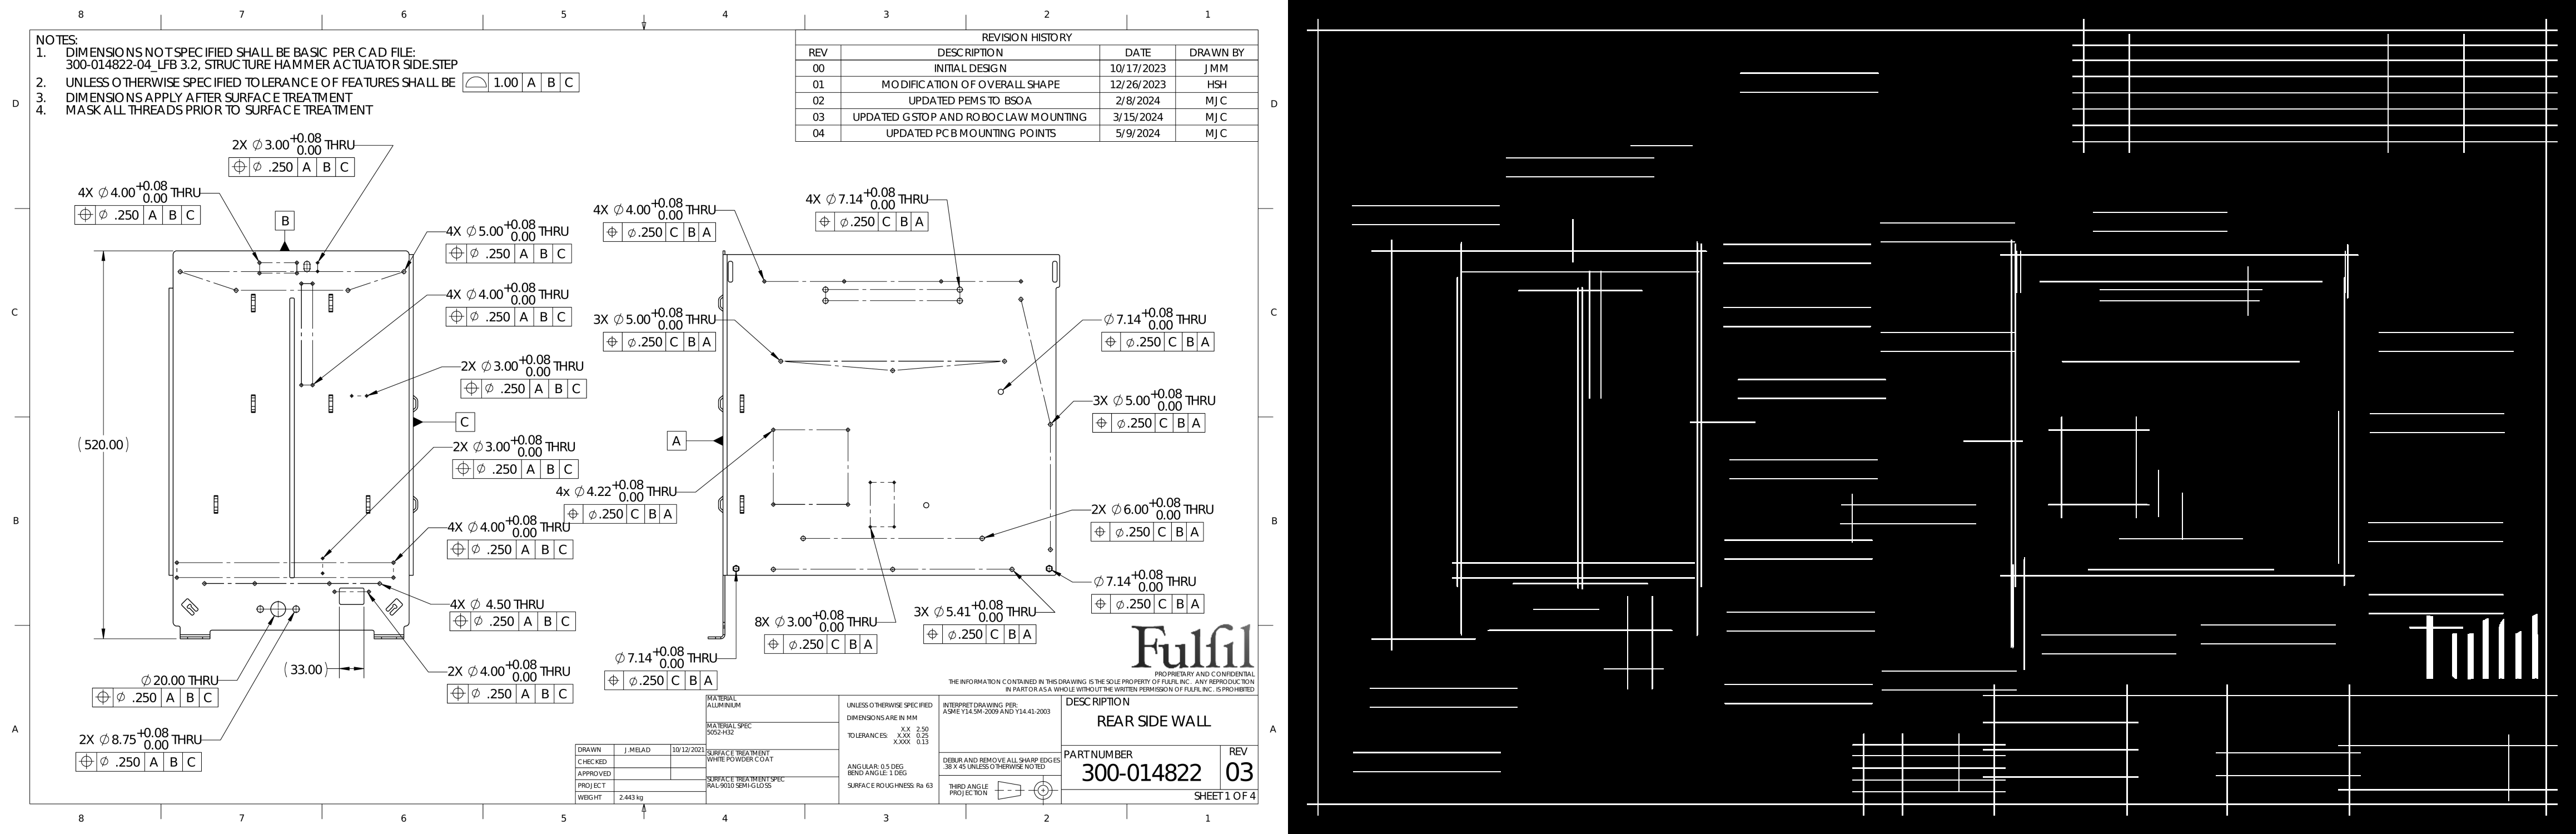

In [6]:
Image.fromarray(np.hstack((gray, merged_lines)))

1


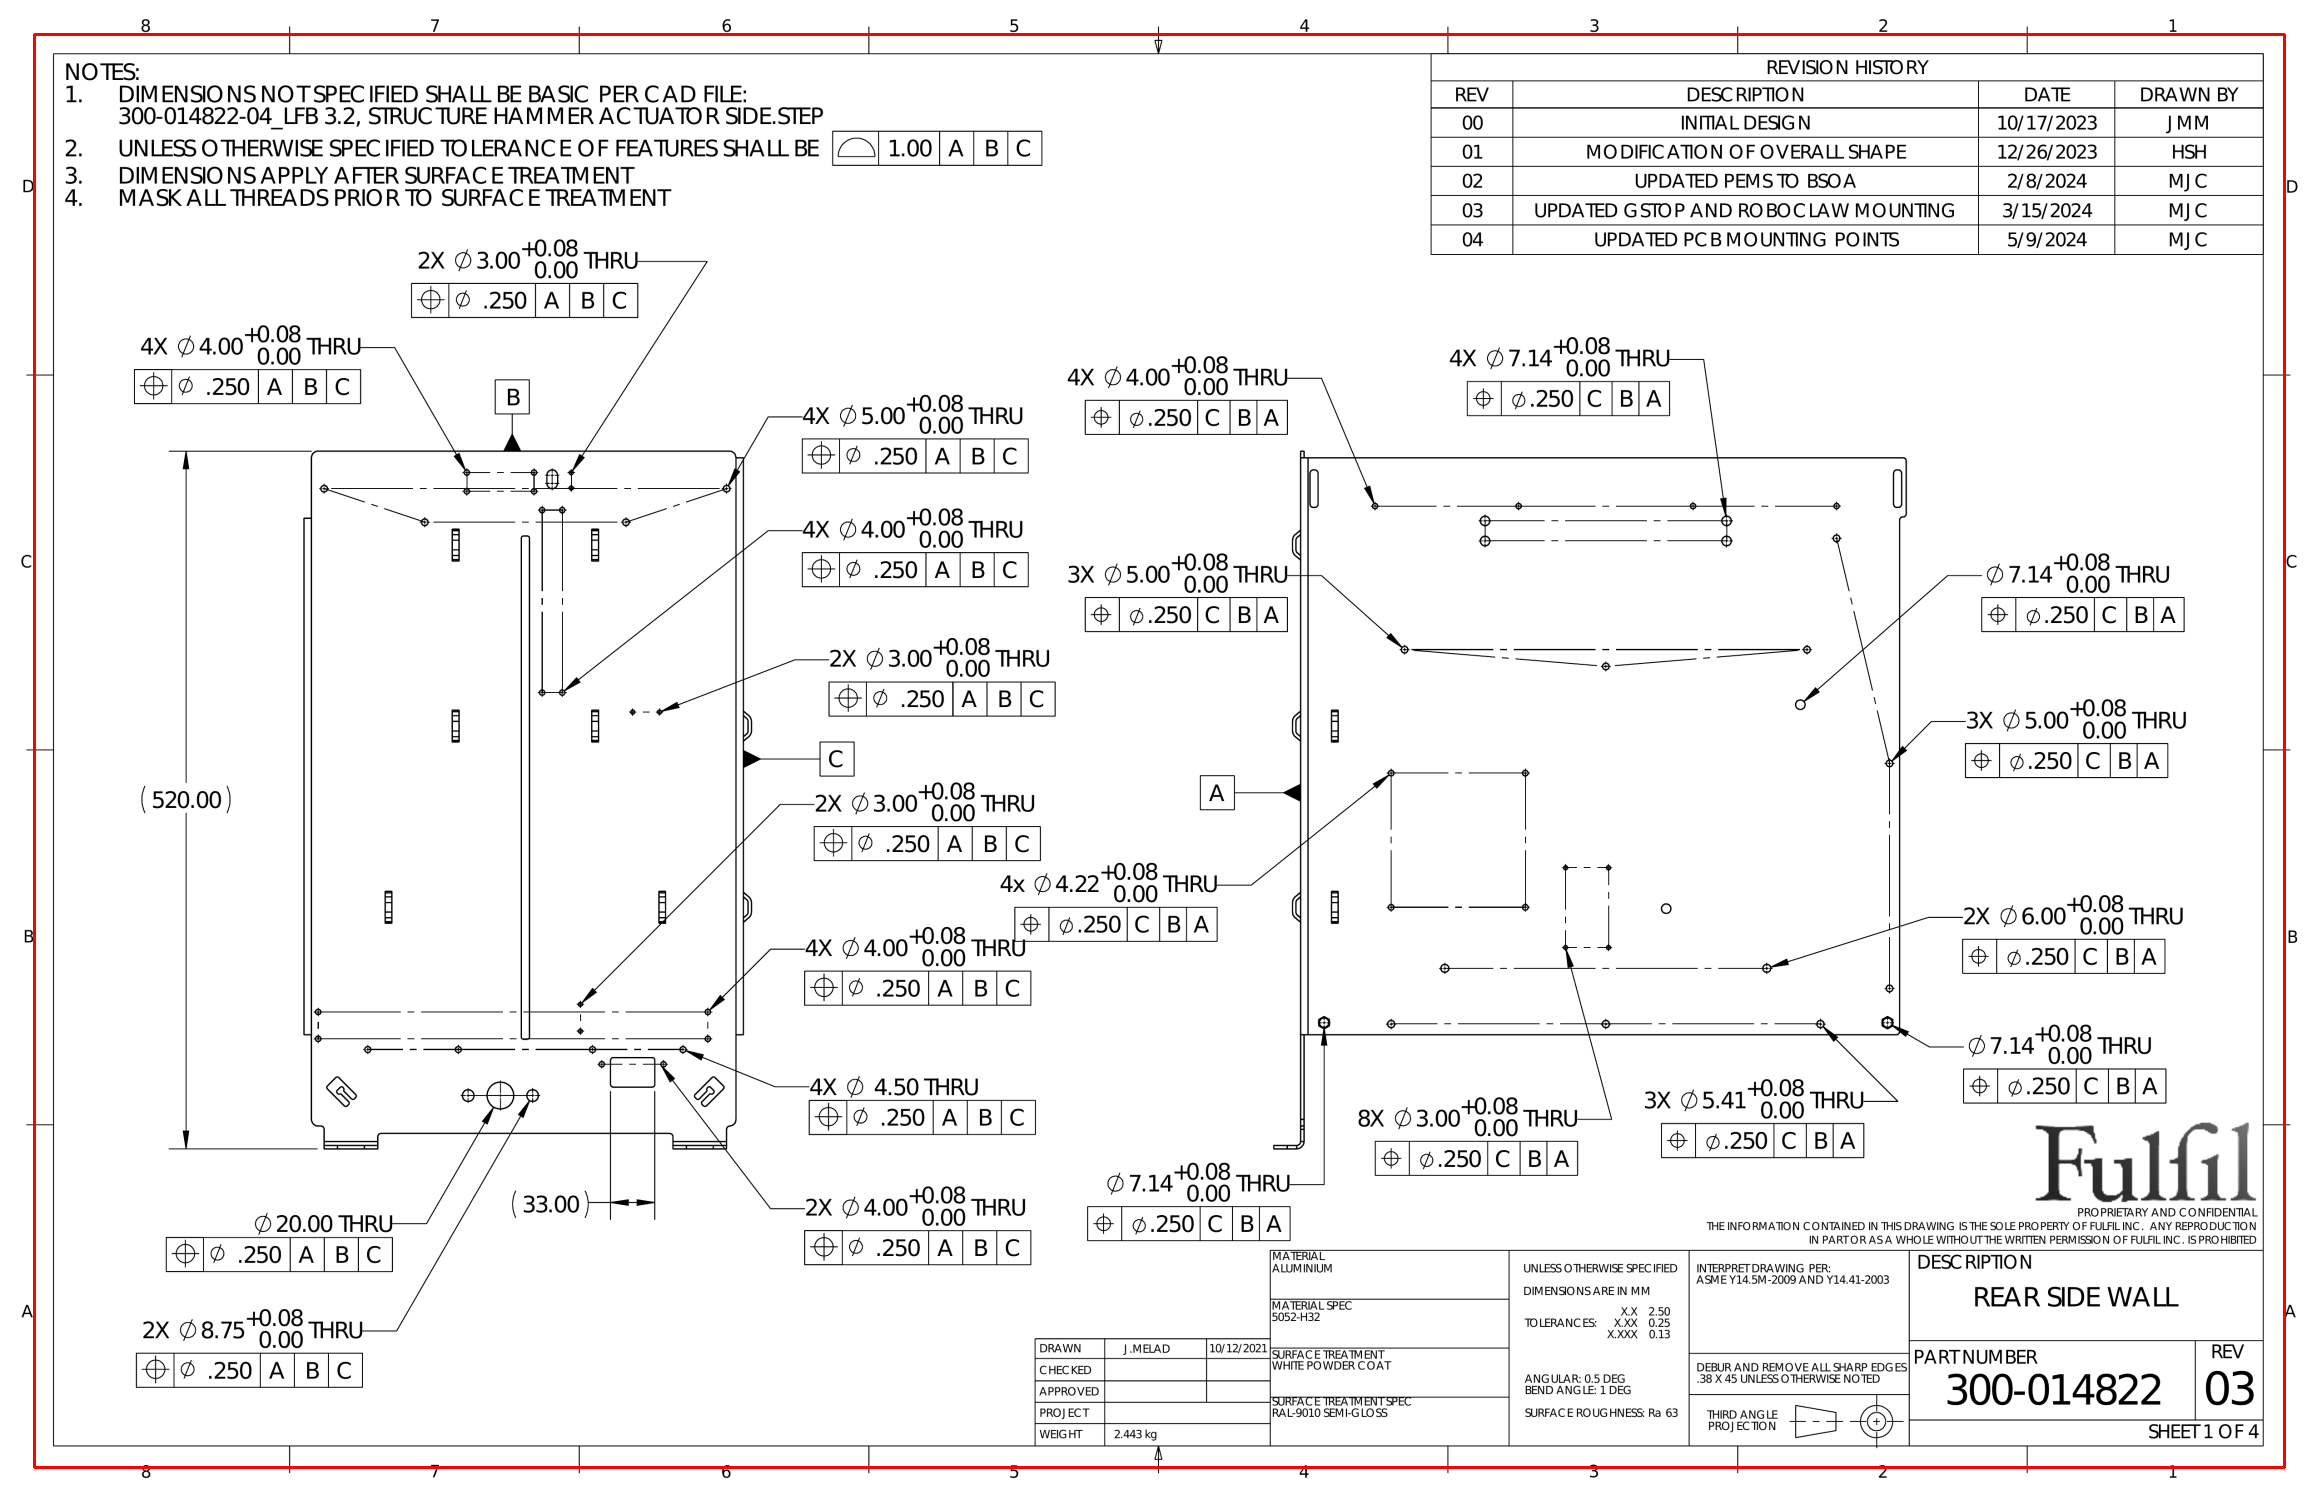

In [7]:
_, binary = cv2.threshold(merged_lines, 128, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
img_comp = img.copy()

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / float(h)
    area = w * h

    if area > 1000 and (0.5 < aspect_ratio < 10):
        cv2.rectangle(img_comp, (x, y), (x + w, y + h), (255, 0, 0), 2)

Image.fromarray(img_comp)

In [8]:
mask = merged_lines.copy()
contours, heirarchy = cv2.findContours(
    mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
)

MIN_TABLE_AREA = 1
contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
epsilons = [0.1 * p for p in perimeter_lengths]
approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

bounding_rects

[(34, 34, 2250, 1433)]